# Import bibliothèques

In [1]:
import configparser
import pandas

from PIL import Image
import io
import os
import numpy as np

import boto3

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, DataType, FloatType
from pyspark.sql.functions import udf

# Taches machine learning
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA

import matplotlib.pyplot as plt
plt.style.use('seaborn')

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/OC_P08/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/OC_P08/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/OC_P08/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anacond

In [2]:
# pyspark --master spark://127.0.0.1:7077 --driver-memory 8g

In [3]:
class UDFException(Exception):
    pass

# Récupération du profil S3

In [4]:
aws_profile = "default"

config = configparser.ConfigParser()
config.read(os.path.expanduser("../../.aws/credentials"))
access_id = config.get(aws_profile, "aws_access_key_id".upper()) 
access_key = config.get(aws_profile, "aws_secret_access_key".upper())

In [5]:
session = boto3.Session(
    aws_access_key_id=access_id,
    aws_secret_access_key=access_key,
)

## Test de lecture

In [6]:
s3 = session.resource('s3')
bucket = s3.Bucket("fruits-oc-p08")
obj = bucket.Object(key='sample/apple_golden_1/r0_107.jpg')
response = obj.get()
file_stream = response[u'Body']
im = Image.open(file_stream)
im = im.resize((224,224))
im_arr = np.asarray(im)

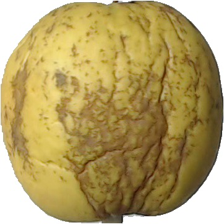

In [7]:
im

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('APP_P08') \
                    .config("spark.driver.memory", "16g") \
                    .config("spark.executor.memory", "16g") \
                    .getOrCreate()

22/03/09 13:45:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [9]:
spark

In [10]:
sc = spark.sparkContext

# Création SparkDataFrame a partir des données S3

## Récupération des liens

In [11]:
paths = []
for file in bucket.objects.all():
    if file.key.split('/')[0] == 'sample':
        paths.append(file.key)
    
rdd_paths = sc.parallelize(paths)
row_rdd_paths = rdd_paths.map(lambda x: Row(x))

In [12]:
images_df = spark.createDataFrame(row_rdd_paths, ['path'])
images_df.persist(pyspark.StorageLevel.DISK_ONLY)

DataFrame[path: string]

In [13]:
# images_df.show(6)

## Récupération des categs

In [14]:
def get_categ(path):
    folder_name = path.split('/')[1]
    categ = folder_name.split('_1')[0]
    return categ

In [15]:
udf_categ = udf(get_categ, StringType())
images_df = images_df.withColumn('categ', udf_categ('path'))

In [16]:
# images_df.show(6, truncate=60)

## Récupération des images

In [17]:
def get_image(path):
    s3 = session.resource('s3')
    bucket = s3.Bucket("fruits-oc-p08")
    obj = bucket.Object(key=path)
    response = obj.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    im_resized = im.resize((20, 20))
    return np.array(im_resized).flatten().tolist()

In [18]:
len(get_image('sample/apple_golden_1/r0_107.jpg'))

1200

In [19]:
udf_image = udf(get_image)

In [20]:
images_df = images_df.withColumn('data', udf_image('path'))

In [21]:
# images_df.show(6, truncate=60)

## Création des vecteurs

In [22]:
# conversion format vecteur dense
udf_vecto = udf(lambda r: Vectors.dense(r), VectorUDT())
images_df = images_df.withColumn('data', udf_vecto('data'))

## Standardisation

In [23]:
#standardisation des données
standardizer = StandardScaler(inputCol="data", outputCol="data_scale", withStd=True, withMean=True)
model_std = standardizer.fit(images_df)
images_df = model_std.transform(images_df)

In [24]:
images_df = images_df.drop('data')

In [25]:
images_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- categ: string (nullable = true)
 |-- data_scale: vector (nullable = true)



# Entrainement PCA

In [26]:
pca_obj = PCA(k=100, inputCol='data_scale')
pca_model = pca_obj.fit(images_df)

[Stage 7:>                                                          (0 + 8) / 8]22/03/09 13:45:47 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/03/09 13:45:47 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/03/09 13:45:48 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/03/09 13:45:48 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-7
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 8 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info #287: KMP_AFFINITY: topology layer "LL cache" is equivalent to "socket".
OMP: Info #287: KMP_AFFINITY: topology layer "L3 cache" is equivalent to "socket".
OMP: Info #287: KMP_AFFINITY: topology layer "L2 cache" is equivalent to "core".
OMP: Info #287: KMP_AFFINITY: topology layer "L1 cache" is equivalent to "core".
OMP: Info #192: KMP_AFFINITY: 1 socket x 8 cores/socket x 1 thread/core (8 total cores)
OMP: Info #218: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #172: KMP_AFFINITY: OS proc 0 maps to socket 0 core 0 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 1 maps to socket 0 core 1 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 2 maps to socket 0 core 2 thread 0 
OMP: Info #172: KMP_AFFINITY: OS proc 3 maps to socket 0 core 3 thread 0 
OMP: Info #1

Text(0, 0.5, 'Variance cumulée')

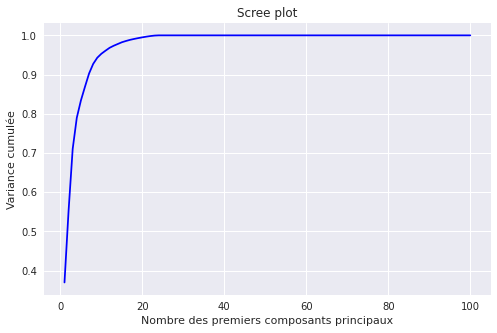

In [27]:
eVc = pca_model.explainedVariance.cumsum()
#plt.rcParams['figure.facecolor']='w'
plt.figure(figsize=(8,5))
plt.plot(range(1,len(eVc)+1), eVc, color='b', linestyle='-')
plt.title('Scree plot')
plt.xlabel('Nombre des premiers composants principaux')
plt.ylabel('Variance cumulée')

### On prend 20 composantes principales

In [28]:
pca_obj = PCA(k=20, inputCol='data_scale', outputCol='pca_features_classic')
pca_model = pca_obj.fit(images_df)

In [29]:
images_df = pca_model.transform(images_df)

In [30]:
# images_df.show(6)

In [31]:
images_df = images_df.drop('data_scale')

In [32]:
images_df.persist(pyspark.StorageLevel.DISK_ONLY)

DataFrame[path: string, categ: string, pca_features_classic: vector]

# Extraction des features avec VGG16

In [33]:
def get_vgg16_features(path):
    try:
        virgin_vgg16 = VGG16()
    except:
        raise UDFException("Can't create virgin")
        
    try:
        model_vgg16 = Model(inputs=virgin_vgg16.inputs, outputs=virgin_vgg16.layers[-2].output)
    except:
        raise UDFException("can't make custom")
        
    try:
        s3 = session.resource('s3')
        bucket = s3.Bucket("fruits-oc-p08")
        obj = bucket.Object(key=path)
        response = obj.get()
        file_stream = response['Body']
    except:
        raise UDFException("can't read image")
        
    try:
        im = Image.open(file_stream)
        im = im.resize((224, 224))
        im = img_to_array(im)
        im = im.reshape(1, 224, 224, 3)
        im = preprocess_input(im)
    except:
        raise UDFException("can't preprocess")
        
    try:
        features = model_vgg16.predict(im).ravel().tolist()
    except:
        raise UDFException("can't predict")
        
    return features

In [34]:
udf_vgg_features = udf(get_vgg16_features)

In [35]:
images_df = images_df.withColumn('vgg_features', udf_vgg_features('path'))

In [36]:
# images_df.show(6)

In [37]:
udf_vecto = udf(lambda r: Vectors.dense(r), VectorUDT())

In [38]:
images_df = images_df.withColumn('vgg_features', udf_vecto('vgg_features')).persist(pyspark.StorageLevel.DISK_ONLY)

In [39]:
images_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- categ: string (nullable = true)
 |-- pca_features_classic: vector (nullable = true)
 |-- vgg_features: vector (nullable = true)



In [40]:
standardizer_vgg = StandardScaler(inputCol="vgg_features", outputCol="vgg_features_scale", withStd=True, withMean=True)
model_std_vgg = standardizer_vgg.fit(images_df)
images_df = model_std_vgg.transform(images_df)

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/OC_P08/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/OC_P08/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/OC_P08/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecate

/home/ubuntu/anaconda3/envs/OC_P08/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/OC_P08/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/OC_P08/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/OC_P08/lib/python3

OMP: Info #254: KMP_AFFINITY: pid 1490 tid 1973 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 1539 tid 1978 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 1484 tid 1975 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 1642 tid 2008 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 1504 tid 1982 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 1639 tid 1986 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 1545 tid 1984 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 1639 tid 2177 thread 2 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 1498 tid 1980 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 1639 tid 2179 thread 4 bound to OS proc set 4
OMP: Info #254: KMP_AFFINITY: pid 1504 tid 2181 thread 2 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 1504 tid 2182 thread 3 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 1639 t

In [41]:
# images_df.show(6, truncate=60)

In [42]:
images_df = images_df.drop('vgg_features')

In [43]:
pca_obj = PCA(k=100, inputCol='vgg_features_scale')
pca_model = pca_obj.fit(images_df)

Text(0, 0.5, 'Variance cumulée')

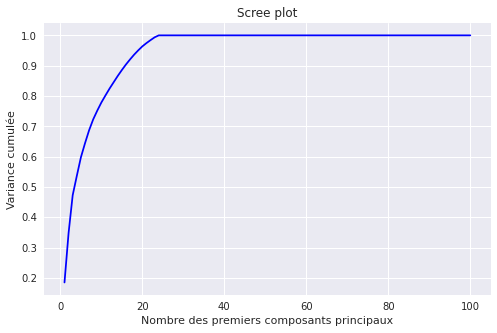

In [44]:
eVc = pca_model.explainedVariance.cumsum()
#plt.rcParams['figure.facecolor']='w'
plt.figure(figsize=(8,5))
plt.plot(range(1,len(eVc)+1), eVc, color='b', linestyle='-')
plt.title('Scree plot')
plt.xlabel('Nombre des premiers composants principaux')
plt.ylabel('Variance cumulée')

### On prend 24 composantes principales

In [45]:
pca_obj = PCA(k=24, inputCol='vgg_features_scale', outputCol='pca_features_vgg')
pca_model = pca_obj.fit(images_df)

In [46]:
images_df = pca_model.transform(images_df).persist(pyspark.StorageLevel.DISK_ONLY)

## Conversion Pandas

In [47]:
images_df_pandas = images_df.toPandas()

# Sauvegarde dans S3

In [48]:
from io import StringIO

In [49]:
csv_obj = StringIO()
images_df_pandas.to_csv(csv_obj)
s3.Object('fruits-oc-p08', "results/results_sample_cloud_1.csv").put(Body=csv_obj.getvalue())

{'ResponseMetadata': {'RequestId': 'KCEXQKD3C4D6JQ63',
  'HostId': 'CjWCsGIr4zf7iEOOVlpXLFxgOEe3cMXk1/mI90E+0Ygg/Nuv/42FeowfHanyBWJezXyxFJvfTlw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'CjWCsGIr4zf7iEOOVlpXLFxgOEe3cMXk1/mI90E+0Ygg/Nuv/42FeowfHanyBWJezXyxFJvfTlw=',
   'x-amz-request-id': 'KCEXQKD3C4D6JQ63',
   'date': 'Wed, 09 Mar 2022 13:54:51 GMT',
   'etag': '"13b249db056f0d2d543c5c4e4d42f43f"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"13b249db056f0d2d543c5c4e4d42f43f"'}

In [50]:
images_df_pandas

,path,categ,pca_features_classic,vgg_features_scale,pca_features_vgg
0,sample/apple_golden_1/r0_107.jpg,apple_golden,"[4.983225157271349, 2.9981240135138223, -13.21...","[0.0, -0.4255353302557893, -0.4189829143659602...","[-3.824722788532722, -14.344125648944358, 14.6..."
1,sample/apple_golden_1/r0_171.jpg,apple_golden,"[9.610643703134516, -1.2338946724611204, -21.5...","[0.0, -0.4255353302557893, -0.4189829143659602...","[-2.440225168341335, -18.48916987001482, 12.18..."
2,sample/apple_golden_1/r1_147.jpg,apple_golden,"[6.137589049969881, -0.12308755848614722, -12....","[0.0, -0.4255353302557893, -0.4189829143659602...","[4.110654031427471, -16.737005488398843, 17.75..."
3,sample/apple_golden_1/r1_175.jpg,apple_golden,"[7.466524318656489, 1.7919673145063495, -19.34...","[0.0, -0.4255353302557893, 1.9590685033076438,...","[4.940315839933582, -16.949512671517592, 17.18..."
4,sample/apple_golden_1/r1_239.jpg,apple_golden,"[8.934278821468462, 1.2486121525460057, -17.14...","[0.0, -0.4255353302557893, -0.4189829143659602...","[2.4293067809220954, -18.307342444434433, 6.90..."
5,sample/cabbage_white_1/r0_139.jpg,cabbage_white,"[6.356740101728814, -8.748284267485586, -9.511...","[0.0, -0.4255353302557893, -0.4189829143659602...","[-29.997270070764053, 22.71680669153922, 18.35..."
6,sample/cabbage_white_1/r0_15.jpg,cabbage_white,"[9.793697329284383, -8.594074560740351, -12.97...","[0.0, -0.4255353302557893, -0.4189829143659602...","[-26.94796811529901, 27.275723555120386, 15.83..."
7,sample/cabbage_white_1/r0_159.jpg,cabbage_white,"[8.119063502459557, -7.494255287809179, -12.74...","[0.0, -0.4255353302557893, -0.4189829143659602...","[-31.691321443497273, 29.390412330115858, 17.3..."
8,sample/cabbage_white_1/r0_63.jpg,cabbage_white,"[8.117989252094212, -8.159591282814803, -8.722...","[0.0, -0.4255353302557893, -0.4189829143659602...","[-30.346907043427986, 27.305055892021457, 17.9..."
9,sample/cabbage_white_1/r0_91.jpg,cabbage_white,"[8.959357982202034, -7.772027303780733, -12.44...","[0.0, -0.4255353302557893, -0.4189829143659602...","[-28.56211900516884, 25.49870759960925, 16.686..."


In [51]:
sc.uiWebUrl

'http://ip-172-31-3-68.eu-west-3.compute.internal:4040'